In [1]:
import msprime
import numpy as np
from IPython.display import SVG
%load_ext rpy2.ipython
# %reload_ext rpy2.ipython

# A state space model for mutations along two genomes

## State space model: Simonsen-Chrchill framework

This is the full transition rate matrix:

In [2]:
%%R

ARGRateM_slow <- function(rho){
  RateM <-
    matrix(c(0,rho,0,0,0,0,0,1,
             1,0,rho/2,1,1,0,0,0,             
             0,4,0,0,0,1,1,0,
             0,0,0,0,0,rho/2,0,1,
             0,0,0,0,0,0,rho/2,1,
             0,0,0,2,0,0,0,1,
             0,0,0,0,2,0,0,1,
             0,0,0,0,0,0,0,0),nrow=8,ncol=8,byrow=TRUE)
  ## Get diagonals right (must sum to 0)
  for (rw in 1:8){
    RateM[rw,rw] <- -sum(RateM[rw,])
  }
  return(RateM)
}

ARGRateMat_slow <- ARGRateM_slow(0.1*2)

ARGRateMat_slow

     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8]
[1,] -1.2  0.2  0.0  0.0  0.0  0.0  0.0    1
[2,]  1.0 -3.1  0.1  1.0  1.0  0.0  0.0    0
[3,]  0.0  4.0 -6.0  0.0  0.0  1.0  1.0    0
[4,]  0.0  0.0  0.0 -1.1  0.0  0.1  0.0    1
[5,]  0.0  0.0  0.0  0.0 -1.1  0.0  0.1    1
[6,]  0.0  0.0  0.0  2.0  0.0 -3.0  0.0    1
[7,]  0.0  0.0  0.0  0.0  2.0  0.0 -3.0    1
[8,]  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0


This is the fast version of the function above, where some of the states are removed from the chain if we are only interested in the heights:

In [3]:
%%R

ARGRateM <- function(rho){
  RateM <-
    matrix(
        c(-(1+rho),        rho,     0, 1,
                 1, -(3+rho/2), rho/2, 2,
                 0,          4,    -6, 2, 
                 0,          0,     0, 0),
        nrow=4,ncol=4,byrow=TRUE)
}

ARGRateMat <- ARGRateM(0.1*2)

ARGRateMat

     [,1] [,2] [,3] [,4]
[1,] -1.2  0.2  0.0    1
[2,]  1.0 -3.1  0.1    2
[3,]  0.0  4.0 -6.0    2
[4,]  0.0  0.0  0.0    0


Equation (1) and figure 2A can be coded this way:

In [4]:
%%R


library("tidyverse")
library('expm')
library('reshape2')
library('patchwork')

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘Matrix’


R[write to console]: The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


R[write to console]: 
Attaching package: ‘expm’


R[write to console]: The following object is masked from ‘package:Matrix’:

    expm


R[write to console]: 
Attaching package: ‘reshape2’


R[write to console]: The following object is masked from ‘package:tidyr’:

    smiths




In [5]:
%%R



n <- 1000
s <- seq(from=0.001, to=4.0,length=n)

# Table with the values
tab_dat <- expand.grid(
        s_tib = s, 
        rho_tib = c(0.02, 0.2, 0.5, 2.5)) %>%
    # For each row
    rowwise() %>%
    # Get the probablity by applying eq. (1)
    mutate(
        den = (exp(s_tib)*expm(ARGRateM(rho_tib)*s_tib)[1,1])) %>%
    ungroup() %>%
    mutate(
        Recombination = as.character(rho_tib)
    )
    
    
plt <- tab_dat %>% 
    ggplot() + 
    geom_line(aes(s_tib, den, color = Recombination)) +
    theme_minimal() +
    ylab('Probability of the same tree height') +
    xlab('Left tree height (s)')
    
ggsave('images/plt_P_same_height.png', plt, width = 8, height = 5)


<img src="images/plt_P_same_height.png" alt="Drawing" style="width: 8in;"/>

The following code is for reproducing figure 2B from equation (2):

In [6]:
%%R

# This function is the variable part
# within equation (2), this is, the 
# numerator
ARGTrns <- function(rho, s, t){
    ARGRateMat <- ARGRateM(rho)
    expm.s <- expm(ARGRateMat*s)
    exp(-(t-s))*(expm.s[1,2]+expm.s[1,3])
    
}

# Define the data frame with array of t
# and different values of rho and base s
n <- 1000
t <- seq(from=0.001, to=4.0,length=n)  
tab_dat <- expand.grid(
        t_tib = t, 
        rho_tib = c(0.02, 2.5), 
        s_tib = c(0.5, 2)) %>% 
    # For each row
    rowwise() %>%
    mutate(
        # Calculate numerator
        den = 
            ifelse(
                t_tib > s_tib, 
                ARGTrns(rho_tib, s_tib, t_tib),
                ARGTrns(rho_tib, t_tib, s_tib)),
        # Divide by denominator
        den = 
            den/(exp(-s_tib)-expm(ARGRateM(rho_tib)*s_tib)[1,1])) %>%
    ungroup() %>%
    mutate(
        Recombination = as.character(rho_tib),
        s = as.character(s_tib)
    )
    
plt <- tab_dat %>% 
    ggplot() + 
    geom_line(aes(t_tib, den, color = Recombination, linetype = s)) +
    theme_minimal() +
    ylab('Density') +
    xlab('Right tree height (t)') +
    ggtitle('Density of t conditional on being different from s')

ggsave('images/plt_density_conditional.png', plt, width = 8, height = 5)

<img src="images/plt_density_conditional.png" alt="Drawing" style="width: 8in;"/>

## Time discretization: setting up the finite state HMM

In [7]:
%%R

FastTransMat <- function(tm,rho){
  # This produces a rate matrix which has an additional state,
  # number 4, which represents states 4, 5, 6 and 7 of the 
  # 'slow' matrix. Thus, state 5 corresponds to the absorbing
  # state, i.e. state 8 in the 'slow' matrix. 
  rate_mat <- matrix(c(-(1+rho),rho,0,0,1,
                              1,-(3+rho/2),rho/2,2,0,             
                              0,4,-6,2,0,
                              0,0,0,-1,1,
                              0,0,0,0,0),
                            nrow=5,ncol=5,byrow=TRUE)
  nInt <- length(tm) ## Number of intervals
  tm0 <- c(0,tm) ## tm0 is tm with time 0 added
  ##-------------------------------------
  JointMat <- matrix(0,nrow=nInt,ncol=nInt) ## Joint prb matrix
  for (j in 1:(nInt-1)){  ## Left state
    for (k in j:nInt){  ## Right state
      if (j<k){
        JointMat[j,k] <-
          expm(tm0[j]*rate_mat)[1,1:3]%*%
          expm((tm[j]-tm0[j])*rate_mat)[1:3,4]*
          exp(-(tm0[k]-tm[j]))*
          # which is the same as 
          # expm((tm0[k]-tm[j])*rate_mat)[4,4]*0.5*
            (1-exp(-(tm[k]-tm0[k])))*0.5
            # which is the same as 
            # expm((tm[k]-tm0[k])*rate_mat)[4,5]
            # but because expm can't handle infinity, 
            # we need to do a workaround 
        # Symmetrize
        JointMat[k,j] <- JointMat[j,k]
      }
      if (j==k){
        JointMat[j,k] <-
          expm(tm0[j]*rate_mat)[1,1:3]%*%
          expm((tm[j]-tm0[j])*rate_mat)[1:3,5]
      }
    }
  }
  ## Final entry
  JointMat[nInt,nInt] <- sum(expm(tm0[nInt]*rate_mat)[1,1:3])
  ## Again: expm can't handle infinity, and state 8 is absorbing
  ## Transition matrix 
  TransMat <- JointMat/rowSums(JointMat)
  return(TransMat)
}


In [8]:
%%R

nInt <- 20
tm <- -log(1-1:(nInt)/nInt)
rho <- 0.1*2
TransM <- FastTransMat(tm, rho)

print(tm)
print(diag(TransM))
print(length(tm))
length(diag(TransM))

 [1] 0.05129329 0.10536052 0.16251893 0.22314355 0.28768207 0.35667494
 [7] 0.43078292 0.51082562 0.59783700 0.69314718 0.79850770 0.91629073
[13] 1.04982212 1.20397280 1.38629436 1.60943791 1.89711998 2.30258509
[19] 2.99573227        Inf
 [1] 0.9951841 0.9857877 0.9764774 0.9672275 0.9580089 0.9487883 0.9395264
 [8] 0.9301772 0.9206851 0.9109823 0.9009846 0.8905853 0.8796464 0.8679849
[15] 0.8553512 0.8413964 0.8256254 0.8073779 0.7864068 0.7864068
[1] 20
[1] 20


# Simulation of the ancestral history

We can now simulate the ancestral history of 2 haploid samples under the coalescent with recombination using msprime.

In [9]:
ts = msprime.sim_ancestry(
    samples=2,
    recombination_rate=0.1,
    sequence_length=100_000,
    random_seed = 19283,
    population_size = 1,
    ploidy = 1
)
# Visualise the simulated ancestral history.
# SVG(ts.draw_svg())

We can now calculate the number of sites belonging to each tree inferred by msprime, together with the number of transitions between the trees: 

In [10]:
# Create a matrix with 0 values
trans_mat = np.zeros((ts.num_nodes-2, ts.num_nodes-2))
first = True
# For each tree
for tree in ts.trees():
    # If not the first iteration
    if not first:
        # Count transition
        trans_mat[n_prev, tree.root-2] += 1
    # Update previous iteration counter
    n_prev = tree.root-2
    first = False
    # Add number of sites in that tree to diagonal
    trans_mat[tree.root-2, tree.root-2] += tree.span-1

In [11]:
trans_mat[1:10, 1:10]

array([[573.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,  18.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,  63.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0., 452.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,  47.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0., 336.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0., 123.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0., 160.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 204.]])

We can also recover the height  each tree in the simulation:

In [12]:
tree_heights = ts.tables.nodes[2:].asdict()['time'].tolist()
tree_heights[1:10]

[0.029413799649010343,
 0.031895199309473245,
 0.033092924537862244,
 0.03309581676433913,
 0.033096701084145676,
 0.03425193460033188,
 0.03627158567740792,
 0.037551594991322275,
 0.037697582388468084]

We now have all the ingredients to simplify the simulated transition matrix based on the cutpoints defined by the discretized times:

In [13]:
%%R -i trans_mat -i tree_heights

# Import the tre heights as vector
tree_heights <- unlist(tree_heights)

# Create vector for assigning each simulated tree to an interval
cut_vec <- cut(tree_heights, breaks = c(0,tm), labels = FALSE, right = FALSE)

# Create empty matrix with the right dimensions
discrete_mat <- matrix(0, length(tm), length(tm))

# For each interval
for (i in 1:length(tm)) {
    # Save indices of trees belonging to interval i
    vec_idx_i <- which(cut_vec == i)
        # For each interval
        for (j in 1:length(tm)) {
            # Save indices of trees belonging to interval j
            vec_idx_j <- which(cut_vec == j)
            # If both indices are non-empty
            if ((length(vec_idx_i) != 0) & (length(vec_idx_j) != 0)) {
                # Save sum of the sub-matrix
                discrete_mat[i, j] <- 
                    sum(trans_mat[vec_idx_i, vec_idx_j])   
        }
    }
}


print(discrete_mat[1:10, 1:10])

      [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10]
 [1,] 3246    1    2    0    0    1    1    1    1     1
 [2,]    3 4993    3    2    4    2    6    7    5     5
 [3,]    0    5 4472    2    9    3    5    7    6     4
 [4,]    0    2    1 5036   11    6   10   11    6     9
 [5,]    2    2   12   14 5093    9    8   11   14    12
 [6,]    1    4    6    9    5 4772   14   18   24     7
 [7,]    1    2    6   11   14   16 4996   15   22    26
 [8,]    0    6    7    7   12   13   23 4465   25    20
 [9,]    0    7    4   11   12   13   20   26 4651    29
[10,]    1    2    4    3   14   18   18   17   25  4243


In order to get the probabilities, we can divide by the total number per row. In theory, this should be the same as dividing it by the total number per column, but in the simulations there might be some differences due to the matrix not being completely symmetric. Just in case, we can compute the column sums after re-scaling by the row sums to check whether they are roughly the same:

In [14]:
%%R

# Divide by the row sums
discrete_mat <- discrete_mat/rowSums(discrete_mat)

# Check that  rowSums and colSums are roughly equal
print(rowSums(discrete_mat))
print(colSums(discrete_mat))

 [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [1] 0.9978885 1.0003032 0.9976891 1.0003833 1.0016097 0.9992185 1.0025217
 [8] 0.9958251 0.9996184 0.9919288 0.9937481 0.9962931 0.9963169 1.0083009
[15] 1.0044390 0.9997408 1.0151265 1.0088324 0.9860669 1.0041491


We can start comparing the theoretical and the simulated matrices. First, we can compare the diagonal values. 

In [15]:
%%R

plt <- ggplot() +
    geom_point(aes(tm, diag(discrete_mat), color = 'Empirical')) +
    geom_smooth(aes(tm, diag(discrete_mat), color = 'Empirical')) +
    geom_point(aes(tm, diag(TransM), color = 'Theoretical')) +
    geom_step(aes(tm, diag(TransM), color = 'Theoretical'), direction="vh") +
    theme_bw() +
    theme(legend.position = 'bottom') +
    ylab(paste0('P(L = l, R = l)')) +
    xlab(paste0('Left tree height (l)'))
    
ggsave('images/plt_P_diagonal.png', plt, width = 6, height = 5)

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



<img src="images/plt_P_diagonal.png" alt="Drawing" style="width: 6in;"/>

Note that the x values for the points are the upper boundaries in tree height of each of the intervals. 

We can also compute the probability given a certain interval. For example, we can plot the probabilities for when the left tree height is in the interval number 10:

In [16]:
%%R

interval <- 10

plt <- ggplot() +
    geom_point(aes(tm[-interval], discrete_mat[interval,][-interval], color = 'Empirical')) +
    geom_smooth(aes(tm[-interval], discrete_mat[interval,][-interval], color = 'Empirical')) +
    geom_step(aes(tm[-interval], TransM[interval,][-interval], color = 'Theoretical'), direction="vh") +
    geom_point(aes(c(0, tm[-interval]), c(0, TransM[interval,][-interval]), color = 'Theoretical')) +
    theme_bw() +
    theme(legend.position = 'bottom') +
    ylab(paste0('P(L = l, R = r | d_l = ', interval, ')')) +
    xlab(paste0('Left tree height (l)'))
    
ggsave('images/plt_P_given_10.png', plt, width = 6, height = 5)

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



<img src="images/plt_P_given_10.png" alt="Drawing" style="width: 6in;"/>

Note that the x values for the points are the upper boundaries in tree height of each of the intervals. Also, the y value corresponding to the analyzed interval is also removed for simplicity. 

We can also compare the matrices as a whole by plotting them side by side. The color scale is log-transformed to be able to see the values off the diagonal. Also, those values in the simulated matrix with a probability of 0 (because they were not found) are defaulted to the lowest color in the scale:

In [31]:
%%R

plt <- melt(discrete_mat) %>% 
    mutate(type = 'Simulation') %>%
    bind_rows(
        mutate(
            melt(TransM),
            type = 'Theoretical'
        )
    ) %>%
    ggplot() +
    geom_tile(aes(Var2, Var1, fill = value)) +
    scale_y_reverse(breaks = 1:20, expand = c(0, 0)) +
    scale_x_continuous(breaks = 1:20, expand = c(0, 0)) +
    facet_wrap(~type) +
    theme_bw() +
    scale_fill_viridis_c(
        trans = 'log', 
        na.value = hcl.colors(1)
    )

ggsave('images/plt_matrix_heatmap.png', plt, width = 10, height = 5)


<img src="images/plt_matrix_heatmap.png" alt="Drawing" style="width: 10in;"/>

# Mutations

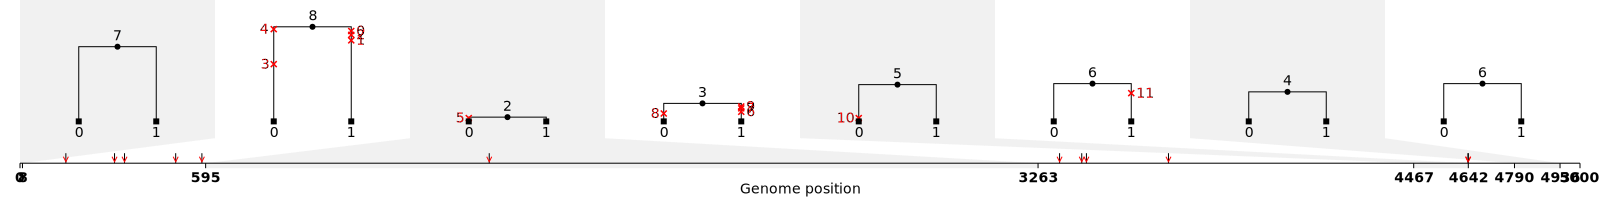

In [116]:
mutated_ts = msprime.sim_mutations(ts, rate=1e-8, random_seed=54300)
SVG(mutated_ts.draw_svg())

In [65]:
mutated_ts.tables.sites

id,position,ancestral_state,metadata
0,131.00000000,T,b''
1,133.00000000,C,b''
2,199.00000000,T,b''
3,264.00000000,A,b''
4,382.00000000,C,b''
5,562.00000000,T,b''
6,586.00000000,A,b''
7,592.00000000,C,b''
8,1741.00000000,A,b''
9,2259.00000000,C,b''


In [66]:
mutated_ts.tables.mutations

id,site,node,time,derived_state,parent,metadata
0,0,1,265107.50463664,A,-1,b''
1,1,1,296295.37901648,T,-1,b''
2,2,1,74972.25545749,C,-1,b''
3,3,1,329837.96865893,T,-1,b''
4,4,0,4392.31161098,A,-1,b''
5,5,1,26648.88196045,G,-1,b''
6,6,1,290594.82877199,G,-1,b''
7,7,0,313563.10963315,T,-1,b''
8,8,1,15258.51418614,T,-1,b''
9,9,0,2983.32249000,A,-1,b''


In [67]:
for variant in mutated_ts.variants():
    print(variant)

Variant(site=Site(id=0, position=131.0, ancestral_state='T', mutations=[Mutation(id=0, site=0, node=1, derived_state='A', parent=-1, metadata=b'', time=265107.50463664)], metadata=b''), alleles=('T', 'A'), genotypes=array([0, 1], dtype=int8))
Variant(site=Site(id=1, position=133.0, ancestral_state='C', mutations=[Mutation(id=1, site=1, node=1, derived_state='T', parent=-1, metadata=b'', time=296295.37901647814)], metadata=b''), alleles=('C', 'T'), genotypes=array([0, 1], dtype=int8))
Variant(site=Site(id=2, position=199.0, ancestral_state='T', mutations=[Mutation(id=2, site=2, node=1, derived_state='C', parent=-1, metadata=b'', time=74972.25545748846)], metadata=b''), alleles=('T', 'C'), genotypes=array([0, 1], dtype=int8))
Variant(site=Site(id=3, position=264.0, ancestral_state='A', mutations=[Mutation(id=3, site=3, node=1, derived_state='T', parent=-1, metadata=b'', time=329837.96865893266)], metadata=b''), alleles=('A', 'T'), genotypes=array([0, 1], dtype=int8))
Variant(site=Site(id

In [70]:
samp_ids = mutated_ts.samples()
print("  ID of diploid individual: ", " ".join([f"{mutated_ts.node(s).individual:3}" for s in samp_ids]))
print("       ID of (sample) node: ", " ".join([f"{s:3}" for s in samp_ids]))
for v in mutated_ts.variants():
    site = v.site
    alleles = np.array(v.alleles)
    print(f"Site {site.id} (ancestral state '{site.ancestral_state}')",  alleles[v.genotypes])
    if site.id >= 4:  # only print up to site ID 4
        print("...")
        break

  ID of diploid individual:    0   0
       ID of (sample) node:    0   1
Site 0 (ancestral state 'T') ['T' 'A']
Site 1 (ancestral state 'C') ['C' 'T']
Site 2 (ancestral state 'T') ['T' 'C']
Site 3 (ancestral state 'A') ['A' 'T']
Site 4 (ancestral state 'C') ['A' 'C']
...


In [113]:
import random

def DNA(length):
    return ''.join(random.choice('CGTA') for i in range(length))

print(DNA(1000))

GTATTGGCAATCTAGTAGAGGACCGGTAGCCCACAGGCGTGTGTGTTCCTTCAAGGATAGAGTAAAAAAATAGAGGCGTCGGTCCGCTAAGCTTAGCATAATCACTCGAGGGTCGACTCTGTAGGGGGCGGGTGCGCAGTCACTTCTACCGACTACTGACTTGAGTAAGATCCACGAGCAGAGGAAGCTCGTCTGGGAACTACATTCGAGCTCAACGGTCTCTGAAGGTAGAGGGATTAGATTATAACCATGTACCGTCAAATGGCGACATGCATGTTAGTTGTGCAGCAGGGCCATTTATTTACCAGTGCTATTTCGGGGCGGACACGTGTCCCCAGACGGGGTCAACAGACCTCCGCGTTGCTAAGAAAATACAACTAATTCGCATTTGTGGCATCTGGTGGTTACTTATGGGTAATTTCTAAAACCAGCGGCAATAGCGGCATAACGACACCGGTACAGGTAGGGCCTAGGTACAGACCATTAATCTACTAATCTGACTATTGCGGTCGTCAGTGTTTTTCCTTTGAGCACTTCATCTCACCGAGCATGATAGTACACTCCCCTTCCACTAGCGGTACCGCTCTCCCTAGAACCAAGTCTCCGCGAAAGGGCATAAATCGGTGCTATAATGAGCACAAGAACGACAGTGCCAAATCGTAGTTCACTTTTAAGACAATTACGATATTCAAACTGGCGAAAGGTAGGGGGAACCAATTTCCGTCACCTTAAGTCACCACAAATAGGATTAAGTGCGAACAGACGTACTATCCGGAATTCACAACTACTCAGTACAATTTCTAGCGGAGCTGGTAAGTTTCCGCTGTTGGATGGCGGACATAAGCACCGCCGTCGATGGAAAACCCCCGGTTAAAGGTAATCTTGGCCTCTGTAAAAACTTAACCAGGCTGCCCTTCATGTCTGGCTTGAAACTTATACACGGAGGCTTTGACCTGTAAGTTCTGTTTACCTAGCAGGCATTGCACCCCCGTTTCCGATG